In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch

from datatools import config, utils, viz_general
from datatools.defcon import DEFCON
from datatools.event_xg import EventXGModel
from datatools.graph_feature import construct_graph_features
from datatools.match import Match
from datatools.tabular_feature import construct_tabular_features

np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.float_format", lambda x: f"{x:.4f}".rstrip("0").rstrip("."))
pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

### Calculating features and labels for the events in a match

In [2]:
match_id = "8qhuektrx8cmkxs11lxsdd4pg"

action_type = "all"
calculate_graphs = False
calculate_tabular = False
load_saved_graphs = True

events = pd.read_csv(f"data/ajax/event_synced/{match_id}.csv", header=0, parse_dates=["utc_timestamp"])
tracking = pd.read_parquet(f"data/ajax/tracking_processed/{match_id}.parquet")
lineups = pd.read_parquet("data/ajax/lineup/line_up.parquet").sort_values("game_date", ignore_index=True)
match_lineup = lineups.loc[lineups["stats_perform_match_id"] == match_id]

match = Match(events, tracking, match_lineup, action_type, include_goals=True)
print("Constructing labels...")
match.labels = match.construct_labels(discount_xg=True)

if load_saved_graphs:
    match.graph_features_0 = torch.load(f"data/ajax/features/action_graphs/{match_id}.pt", weights_only=False)
    match.graph_features_1 = torch.load(f"data/ajax/features/post_action_graphs/{match_id}.pt", weights_only=False)
    match.actions = match.label_post_actions(match.actions)

elif calculate_graphs:
    print("Constructing graph features for actions...")
    match.graph_features_0 = construct_graph_features(match, post_action=False)
    print("Constructing graph features for post-actions...")
    match.graph_features_1 = construct_graph_features(match, post_action=True)

if calculate_tabular:
    print("Constructing tabular features for actions...")
    match.tabular_features_0 = construct_tabular_features(match, post_action=False)
    print("Constructing tabular features for post-actions...")
    match.tabular_features_1 = construct_tabular_features(match, post_action=True)

Constructing labels...


### Estimating component values by trained models

In [4]:
event_xg_model = EventXGModel(unblocked=True)
event_xg_model.train()
device = "cuda:0"

defcon = DEFCON(
    match,
    shot_success="unblocked",
    event_xg_model=event_xg_model,
    select_model_id="action_intent/00",
    pass_success_model_id="pass_success/20",
    shot_block_model_id="shot_blocking/01",
    score_model_id="outcome_scoring/20",
    concede_model_id="outcome_conceding/20",
    posterior_model_id="failure_receiver/21",
    device=device,
)
defcon.estimate_components()

failure_posterior: 100%|██████████| 1162/1162 [00:05<00:00, 201.24it/s]


### Calculating per-player defensive scores

In [5]:
player_scores = defcon.evaluate_players()
player_scores = player_scores[player_scores["mins_played"] >= 45].copy()

defensive_credit:   0%|          | 0/1162 [00:00<?, ?it/s]

defensive_credit: 100%|██████████| 1162/1162 [00:03<00:00, 297.20it/s]


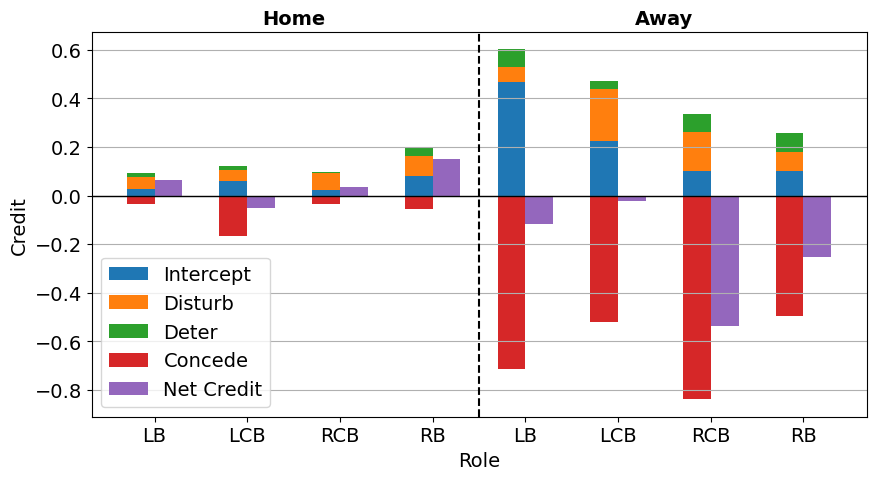

In [7]:
defender_roles = ["LB", "LCB", "RCB", "RB"]
viz_general.plot_player_scores(player_scores, defender_roles)

### Credit gain-loss timeline

In [8]:
credits = defcon.credits[defcon.credits["player_credit"].abs() > 1e-5].copy().reset_index(drop=True)
credits["frame_id"] = defcon.match.actions.loc[credits["index"], "frame_id"].values
credits["team"] = credits["defender"].str[:4]
credits["possessor"] = defcon.match.actions.loc[credits["index"], "object_id"].values
credits["action_type"] = defcon.match.actions.loc[credits["index"], "action_type"].values
credits["defense_type"] = credits["defense_type"].apply(lambda x: x.split("_")[0]).replace("foul", "concede")
credits["x"] = credits.apply(lambda x: defcon.match.tracking.at[x["frame_id"], x["defender"] + "_x"], axis=1)
credits["y"] = credits.apply(lambda x: defcon.match.tracking.at[x["frame_id"], x["defender"] + "_y"], axis=1)

pivot = credits.pivot_table("player_credit", "index", "defender")
sorted_players = sorted(pivot.columns, key=utils.player_sort_key)
action_frames = defcon.match.actions.loc[pivot.index, ["period_id", "frame_id", "synced_ts"]]
actions = pd.concat([action_frames, defcon.epv.loc[pivot.index]], axis=1)

In [ ]:
tracking = defcon.match.tracking
period_ids = actions["period_id"].unique()
fps = 25
xticks, xlabels = [], []

for period_id in period_ids:
    period_frames = tracking[tracking["period_id"] == period_id].index

    for minutes in np.arange(0, 100, 5):
        if period_id < period_ids.max() and minutes >= 45:
            continue

        target_frame = period_frames[0] + minutes * 60 * fps
        if target_frame > period_frames.max():
            continue

        target_xtick = np.searchsorted(action_frames["frame_id"], target_frame) - 0.5
        xticks.append(target_xtick)
        xlabels.append(f"{(period_id - 1) * 45 + minutes}\'")

n_players = len(sorted_players)
ts_arr = np.tile(actions['synced_ts'].astype(str).values, (n_players, 1))
index_arr = np.tile(pivot.index.values, (n_players, 1))
type_arr = np.tile(actions['spadl_type'].astype(str).values,(n_players, 1))
player_arr = np.tile(actions['object_id'].astype(str).values, (n_players, 1))
receiver_arr = np.tile(actions['receiver_id'].astype(str).values,(n_players, 1))
customdata = np.stack([ts_arr, index_arr, type_arr, player_arr, receiver_arr], axis=-1)

hm = go.Heatmap(
    z=pivot[sorted_players].T.values,
    x=np.arange(pivot.shape[0]),
    y=sorted_players,
    zmin=-0.03,
    zmax=0.03,
    colorscale="RdBu",
    reversescale=False,
    customdata=customdata,
    hovertemplate=(
        "Timestamp: %{customdata[0]}<br>"
        "Action index: %{customdata[1]}<br>"
        "Action type: %{customdata[2]}<br>"
        "Action player: %{customdata[3]}<br>"
        "Receiver: %{customdata[4]}<br>"
        "Defender: %{y}<br>"
        "Credit: %{z:.6f}<extra></extra>"
    ),
    showscale=True,
    colorbar=dict(
        thickness=25,
        len=1,
        outlinewidth=0,
        tickfont=dict(size=14),
        ticklen=8,
        ticks="outside",
    ),
)
fig = go.Figure(data=hm)

fig.update_xaxes(
    title="Time (min)",
    title_font=dict(size=16),
    tickmode="array",
    tickvals=xticks,
    ticktext=xlabels,
    tickfont=dict(size=14),
    showgrid=True,
    gridcolor="gray",
)
fig.update_yaxes(
    autorange="reversed",
    title="Defender",
    title_font=dict(size=16),
    tickfont=dict(size=14),
    type="category",
    categoryorder="array",
    categoryarray=sorted_players,
    showgrid=False,
    zeroline=False,
)
fig.update_layout(
    width=1000,
    height=700,
    template="plotly_white",
    margin=dict(l=80, r=60, t=40, b=60)
)

fig.show()

pass from home_0 (0.0032) to away_9 (-0.0158)


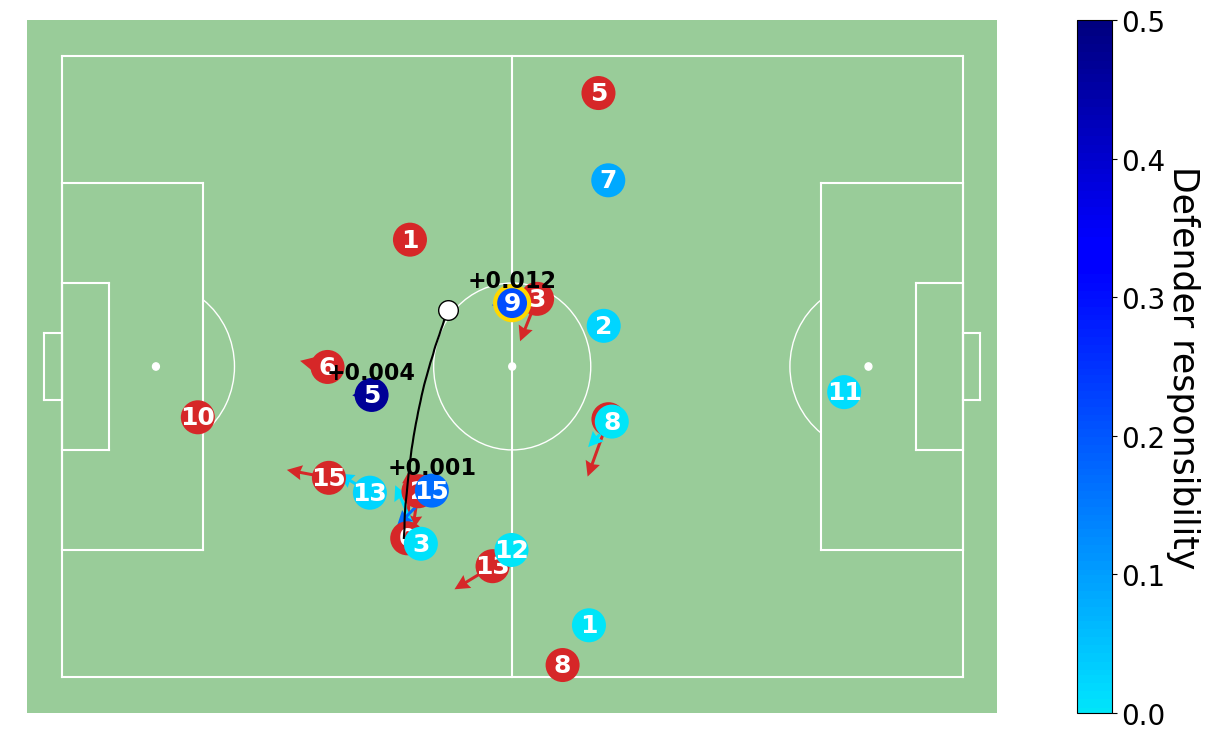

,select,success,s_score,s_concede,s_value,f_score,f_concede,f_value,option_value,advantage
home_0,0.0192,0.4762,0.0119,0.0032,0.0087,0.0046,0.0113,-0.0066,0.0007,0.0154
home_1,0.3122,0.5478,0.0116,0.0031,0.0085,0.0047,0.0099,-0.0052,0.0023,0.0136
home_2,0.2217,0.7219,0.0117,0.003,0.0087,0.0048,0.0109,-0.0061,0.0046,0.0148
home_3,0.0473,0.2588,0.0155,0.0035,0.012,0.0051,0.008,-0.0028,0.001,0.0148
home_4,0.2434,0.3216,0.0182,0.0033,0.0149,0.0057,0.0072,-0.0015,0.0038,0.0164
home_5,0.0104,0.3072,0.0144,0.003,0.0113,0.0047,0.0052,-0.0005,0.0031,0.0119
home_6,0.023,0.7631,0.0092,0.0033,0.0059,0.004,0.018,-0.014,0.0012,0.0199
home_8,0.0043,0.3436,0.0139,0.0032,0.0108,0.0047,0.0052,-0.0005,0.0034,0.0112
home_10,0.0231,0.994,0.0078,0.0036,0.0042,0.0034,0.0248,-0.0214,0.004,0.0256
home_13,0.0438,0.6161,0.0109,0.0034,0.0075,0.0046,0.0082,-0.0037,0.0032,0.0111


In [9]:
event_index = 117
# values_i = defcon.visualize_snapshot(event_index, size="select", color="s_value", annot="success")
values_i = defcon.visualize_snapshot(event_index, annot="player_credit", color="posterior")
values_i

### Positional heat maps

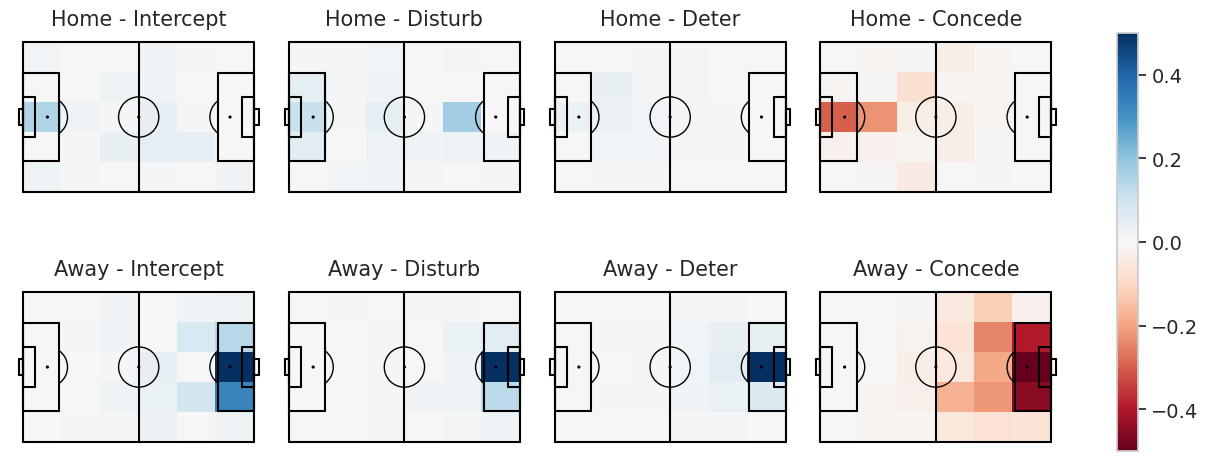

In [10]:
viz_general.draw_pitch_heatmaps(credits)

### Pairwise credit gain-loss matrices

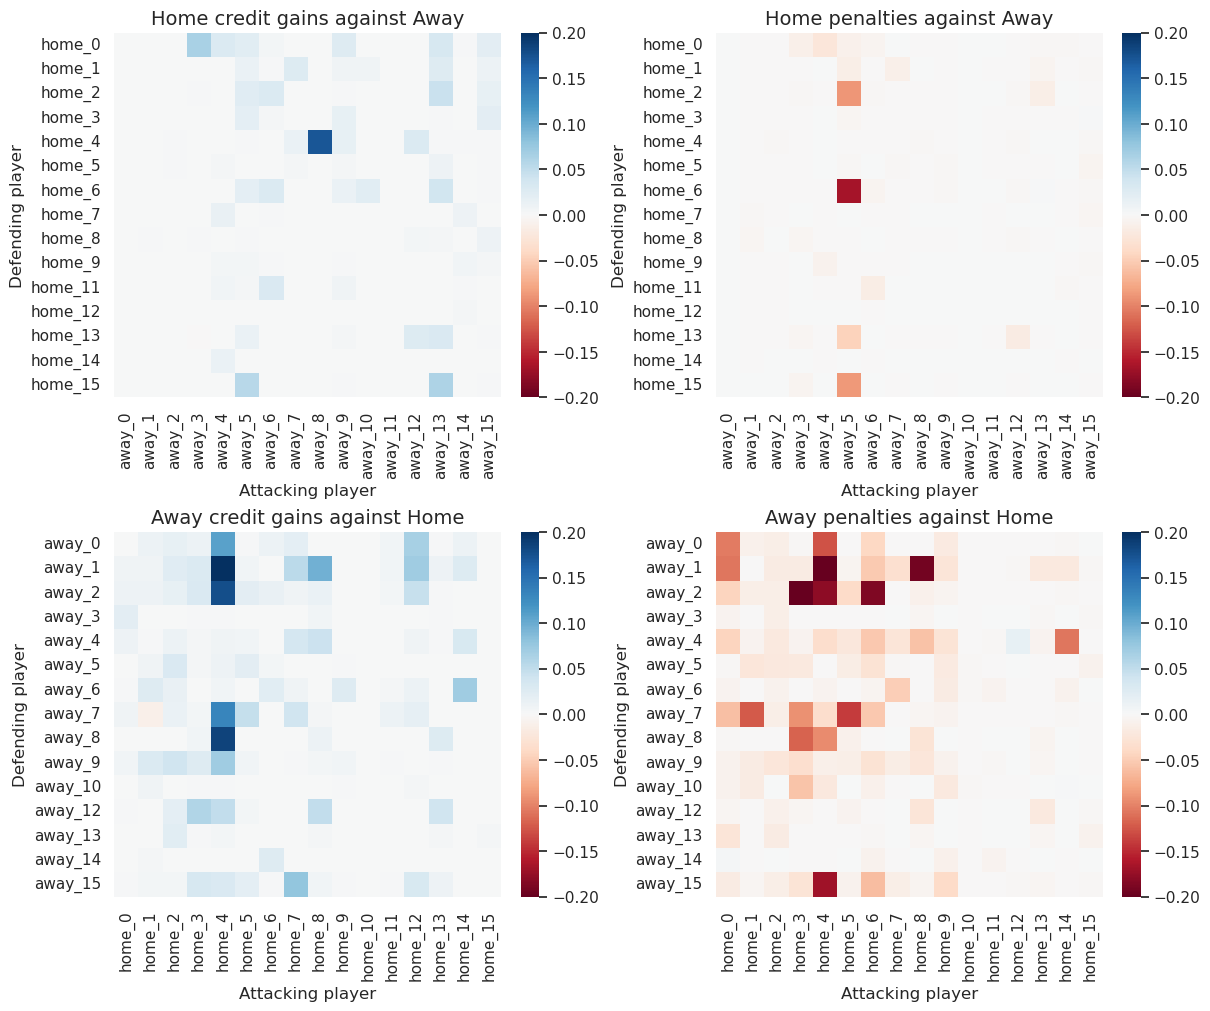

In [12]:
credits_except_gk = credits[~credits["defender"].isin(defcon.match.keepers)].copy()
gain_mats, loss_mats = viz_general.draw_pairwise_matrix_heatmaps(credits_except_gk)

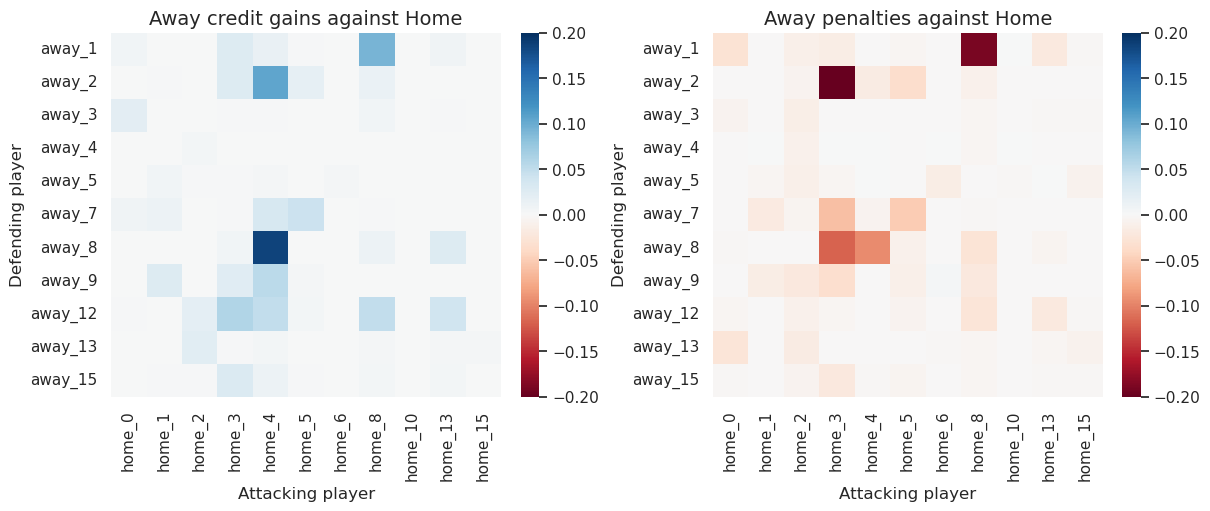

In [35]:
period_actions = defcon.actions[defcon.actions["period_id"] == 1]
period_credits = credits_except_gk[credits_except_gk["index"].isin(period_actions.index)]
gain_mats, loss_mats = viz_general.draw_pairwise_matrix_heatmaps(period_credits, "away")

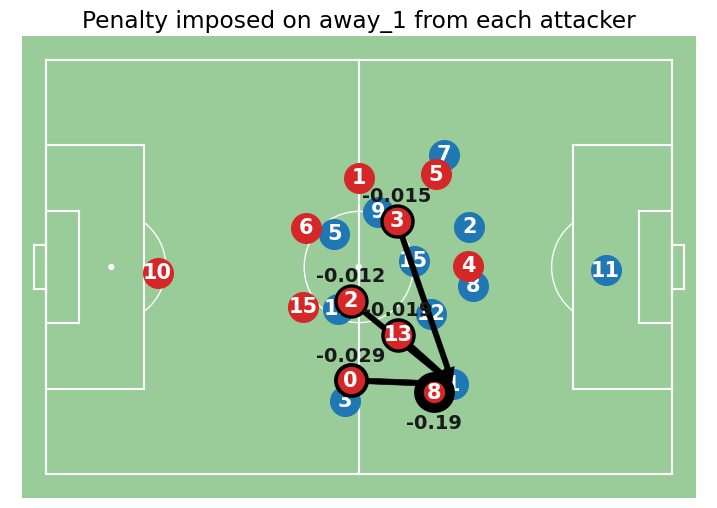

In [40]:
period_tracking = defcon.match.tracking[defcon.match.tracking["period_id"] == 1]
viz_general.draw_player_focused_credits(loss_mats[0], period_tracking, "away_1")